# Sentiment Analysis
### Using GloVe Twitter Embedding and CNN + Bidirectional LSTM 
### 91% Test Accuracy


### Imports and Variables Setup

In [14]:
## Imports
# tf
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import RandomNormal
# others
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [120]:
## variables
USEFUL_COLUMNS = ['review','sentiment']
MAX_LENGTH = 500
FEATURE_SIZE = 200
EPOCHS = 6
BATCHSIZE = 1024
LR = 1e-3
MAX_WORDS = 40000

# path
train_path = "/content/train.csv"
val_path = "/content/val.csv"
test_path = "/content/test.csv"
embedding_path = "/content/drive/MyDrive/for colab/glove.twitter.27B.200d.txt"
model_output_path="/content/drive/MyDrive/saved_models/sentimentAnalysis_gen_1"
index_output_path="/content/drive/MyDrive/saved_models/sentimentAnalysis_gen_1_index.json"

### Data and Embedding setup

In [5]:
## helper steps
!unzip "/content/drive/MyDrive/for colab/IMDB.zip" -d "/content"

Archive:  /content/drive/MyDrive/for colab/IMDB.zip
replace /content/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
## Load data

df_train = pd.read_csv(train_path, usecols=USEFUL_COLUMNS)
df_val = pd.read_csv(val_path, usecols=USEFUL_COLUMNS)
df_test = pd.read_csv(test_path, usecols=USEFUL_COLUMNS)

print(df_train.info())
print("\nTraining data tail:\n",df_train['review'][0])
print("\nTraining data count: ",len(df_train),"\nValidation data count: ",len(df_val),"\nTesting data count: ",len(df_test))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     35000 non-null  object
 1   sentiment  35000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 547.0+ KB
None

Training data tail:
 Having avoided seeing the movie in the cinema, but buying the DVD for my wife for Xmas, I had to watch it. I did not expect much, which usually means I get more than I bargained for. But 'Mamma Mia' - utter, utter cr**. I like ABBA, I like the songs, I have the old LPs. But this film is just terrible. The stage show looks like a bit of a musical, but this races along with songs hurriedly following one another, no characterisation, the dance numbers (which were heavily choreographed according to the extras on the DVD) are just thrown away with only half the bodies ever on screen, the dance chorus of north Europeans appear on a small Greek island at w

In [7]:
## Clean data
def remove_punct(sentences):
  sentences = sentences.replace(',', ' ')
  sentences = sentences.replace('.', ' ')
  sentences = sentences.replace('!', ' ')
  sentences = sentences.replace('?', ' ')
  sentences = sentences.replace('(', ' ')
  sentences = sentences.replace(')', ' ')
  sentences = sentences.replace('\'', ' ')
  sentences = sentences.replace('-', ' ')
  sentences = sentences.replace('*', ' ')
  
  return sentences

df_train['review'] = df_train['review'].apply(lambda x: remove_punct(x))
df_val['review'] = df_val['review'].apply(lambda x: remove_punct(x))
df_test['review'] = df_test['review'].apply(lambda x: remove_punct(x))


In [16]:
## Tokenizer setup
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(df_train['review']))

In [18]:
## Load Embeddings
word_embedding = {}

with open(embedding_path) as f:
  for line in f:
    line_split = line.split()
    word = line_split[0]
    vec = np.asarray(line_split[1:],dtype='float32')
    if len(vec) == FEATURE_SIZE:
      word_embedding[word] = vec

## Embedding setup
word_index = tokenizer.word_index
embedding_matrix_all = np.stack(list(word_embedding.values()))
embedding_mean = embedding_matrix_all.mean()
embedding_std = embedding_matrix_all.std()
embedding_matrix = np.random.normal(embedding_mean, embedding_std, (MAX_WORDS, FEATURE_SIZE))
hits = []
misses = []

for word, i in word_index.items():
  if i < MAX_WORDS:
    vec = word_embedding.get(word)
    if vec is not None:
      embedding_matrix[i] = vec
      hits.append(word)
    else:
      misses.append(word)
print("embedding_matrix shape:", embedding_matrix.shape)
print("hit:", len(hits), "misses:", len(misses))

embedding_matrix shape: (40000, 200)
hit: 35749 misses: 4250


In [26]:
misses[10:50] # mostly numbers

['80',
 '30',
 '6',
 '90',
 '15',
 '50',
 '100',
 '70',
 '11',
 '40',
 '12',
 '000',
 '80s',
 '60',
 '70s',
 '13',
 '0',
 '2001',
 '25',
 '1970',
 'fulci',
 '14',
 '1980',
 '1950',
 '17',
 'mst3k',
 '2005',
 '60s',
 'stanwyck',
 '18',
 '1950s',
 '2006',
 '45',
 '2000',
 '16',
 '24',
 '20th',
 '1st',
 '1970s',
 '1980s']

In [27]:
## data setup
max_length = df_train['review']

x_train = tokenizer.texts_to_sequences(df_train['review'])
x_val = tokenizer.texts_to_sequences(df_val['review'])
x_test = tokenizer.texts_to_sequences(df_test['review'])

x_train = pad_sequences(x_train, maxlen=MAX_LENGTH)
x_val = pad_sequences(x_val, maxlen=MAX_LENGTH)
x_test = pad_sequences(x_test, maxlen=MAX_LENGTH)

y_train = df_train['sentiment']
y_val = df_val['sentiment']
y_test = df_test['sentiment']

# train_sample=tokenizer.texts_to_sequences(train_sample)

### Model Creation

In [106]:
## create model
def create_model():
  i = layers.Input(shape=(MAX_LENGTH,), dtype="int64")
  x = layers.Embedding(MAX_WORDS, FEATURE_SIZE, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix))(i)
  

  x = layers.Conv1D(512, 8, padding='same', activation='relu')(x)
  x = layers.MaxPool1D()(x)
  x = layers.Dropout(0.4)(x)
  
  x = layers.Conv1D(256, 4, padding='same', activation='relu')(x)
  x = layers.MaxPool1D()(x)
  x = layers.Dropout(0.4)(x)

  x = layers.Conv1D(128, 4, padding='same', activation='relu')(x)
  x = layers.MaxPool1D()(x)
  x = layers.Dropout(0.4)(x)

  x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
  x = layers.GlobalMaxPooling1D()(x)

  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dropout(0.4)(x)
  x = layers.Dense(1, activation='sigmoid')(x)

  model = Model(i, x)
  return model

In [122]:
model = create_model()
model.summary()
model.predict(x_train[0].reshape(1,500))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 200)          8000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 512)          819712    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 250, 512)          0         
_________________________________________________________________
dropout (Dropout)            (None, 250, 512)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 250, 256)          524544    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 125, 256)          0     

array([[0.47222146]], dtype=float32)

### Optimizer Creation and Fit Model

In [123]:
## compile and fit the model
loss =  tf.keras.losses.BinaryCrossentropy()
optimizer = Adam(learning_rate = LR)

model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics='binary_accuracy')
r = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCHSIZE, validation_data=(x_val, y_val))

Epoch 1/6
35/35 [==============================] - 71s 2s/step - loss: 0.7019 - binary_accuracy: 0.5101 - val_loss: 0.6880 - val_binary_accuracy: 0.6092
Epoch 2/6
35/35 [==============================] - 66s 2s/step - loss: 0.5425 - binary_accuracy: 0.7244 - val_loss: 0.3791 - val_binary_accuracy: 0.8356
Epoch 3/6
35/35 [==============================] - 66s 2s/step - loss: 0.3302 - binary_accuracy: 0.8606 - val_loss: 0.2728 - val_binary_accuracy: 0.8940
Epoch 4/6
35/35 [==============================] - 66s 2s/step - loss: 0.2285 - binary_accuracy: 0.9108 - val_loss: 0.2483 - val_binary_accuracy: 0.9050
Epoch 5/6
35/35 [==============================] - 66s 2s/step - loss: 0.1773 - binary_accuracy: 0.9350 - val_loss: 0.2464 - val_binary_accuracy: 0.9076
Epoch 6/6
35/35 [==============================] - 66s 2s/step - loss: 0.1421 - binary_accuracy: 0.9502 - val_loss: 0.2310 - val_binary_accuracy: 0.9136


### Model Evaluation

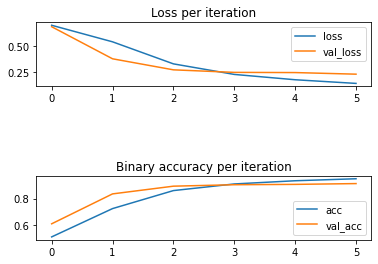

In [124]:
## Model Evaluation
# plot loss per iteration
plt.subplot(3, 1, 1)
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.title('Loss per iteration')
plt.legend()

# Plot accuracy per iteration
plt.subplot(3, 1, 3)
plt.plot(r.history['binary_accuracy'], label='acc')
plt.plot(r.history['val_binary_accuracy'], label='val_acc')
plt.title('Binary accuracy per iteration')
plt.legend()

In [125]:
# Test model on test dataset
print("Test score:", model.evaluate(x_test, y_test))

313/313 [==============================] - 11s 34ms/step - loss: 0.2231 - binary_accuracy: 0.9121
Test score: [0.22305293381214142, 0.9121000170707703]


### Save Model and Word Index

In [127]:
# Save model and word index
f = open(index_output_path, "w")
json.dump(word_index, f)
f.close()

model.save(model_output_path, save_traces=False)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_models/sentimentAnalysis_gen_1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_models/sentimentAnalysis_gen_1/assets


### Disclaimer & References <br>
#### Input data taken from: <br>
> https://www.kaggle.com/ducanger/imdb-dataset <br>

#### Pretrained word embedding taken from: <br>
> GloVe: Global Vectors for Word Representation <br>
https://nlp.stanford.edu/projects/glove/

#### Some codes or ideas are referenced from the following pages: <br>
> NLP Model building[Transformers, Attention & more]: <br>
https://www.kaggle.com/colearninglounge/nlp-model-building-transformers-attention-more#Build-a-Static-Semantic-Embedding-Neural-Network(LSTM)-Baseline

> NLP(End to end): CLL NLP workshop: <br>
https://www.kaggle.com/colearninglounge/nlp-data-preprocessing-and-cleaning

> TF2.0 Spam Detection RNN: <br>
https://colab.research.google.com/drive/1giEoGZzUO_59rDxdxTwpqb2d3gZOJNeH#scrollTo=b6He4SKO-qci